## Imports

In [1]:
import os
current_file_dir = os.getcwd()
os.chdir("../../codes/")

from src.load_explanations import load_explanations_of_many_models, _unify_lenths, _trim_image_path
from src import strings_to_classes_mappings

from src.compare_explanations import compare_explanations, cosine_similarity_distance_with_stdev_and_mean, radial_basis_function_distance_with_stdev_and_mean
from src.load_explanations import load_explanations_of_many_models

os.chdir(current_file_dir)

# Usage example

Get possible models etc.

In [2]:
print("Possible datasets:", list(strings_to_classes_mappings.datasets_mapping.keys()))
print("Possible models:", list(strings_to_classes_mappings.models_mapping.keys()))
print("Possible explanations:", list(strings_to_classes_mappings.explanations_mapping.keys()))
models_list = list(strings_to_classes_mappings.models_mapping.keys())

Possible datasets: ['imagenette2']
Possible models: ['ConvNeXtV2_Nano', 'DeiT_S', 'DeiT_T', 'DenseNet121', 'EfficientNet_B3', 'EfficientNet_B4', 'MobileNetV3', 'PyramidViT_V2_B2', 'Res2Net50', 'ResNet18', 'ResNet50', 'ResNeXt50', 'Swin_T', 'ViT_B_32']
Possible explanations: ['GradCAM', 'IntegratedGradients', 'KernelSHAP']


# Getting data

In [3]:
paths_to_explanations = {
    "GradCAM" : os.path.join(current_file_dir, os.pardir, "20240603-gradcam-512-histograms-clustering"),
    "KernelSHAP" : os.path.join(current_file_dir, os.pardir, "20240613-sample-explanations-kernelshap-ig"),
    "IntegratedGradients" : os.path.join(current_file_dir, os.pardir, "20240613-sample-explanations-kernelshap-ig"),
}

In [4]:
explanations_many_models = load_explanations_of_many_models('imagenette2', models_list, 'KernelSHAP', root_explanations=paths_to_explanations['KernelSHAP'])

Loading explanations: 100%|██████████| 8/8 [00:00<00:00, 727.39it/s]

Loaded 8 common explanations for each model.


In [5]:
explanations_many_models[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions'])

In [6]:
import torch.nn.functional as F

def cosine_similarity(explanations_1, explanations_2):
    """
        in: explanations_1, explanations_2 - torch.tensors of same dimensions, each row is an explanation
        out: cosine similarity of explanations_1 and explanations_2
    """
    explanations_1_flattened = explanations_1.flatten(start_dim=1)
    explanations_2_flattened = explanations_2.flatten(start_dim=1)
    cosine_similarities = F.cosine_similarity(explanations_1_flattened, explanations_2_flattened, dim=1)
    return cosine_similarities.mean().item()

In [7]:
i = 0
j = 1
explanations_i = explanations_many_models[i]['explanations']
explanations_j = explanations_many_models[j]['explanations']
cosine_similarity(explanations_i, explanations_j)

0.9001469016075134

In [8]:
explanations_1_flattened = explanations_i.flatten(start_dim=1)
explanations_2_flattened = explanations_j.flatten(start_dim=1)
cosine_similarities = F.cosine_similarity(explanations_1_flattened, explanations_2_flattened, dim=1)

In [9]:
cosine_similarities

tensor([0.9375, 0.9336, 0.9453, 0.8340, 0.8625, 0.8524, 0.9096, 0.9262])

In [10]:
# print mean and stdev of cosine similarities 
cosine_similarities.mean().item(), cosine_similarities.std().item()

(0.9001469016075134, 0.04375128448009491)

## Update

In [11]:
# from torch import exp
from math import sqrt

# def cosine_similarity_with_stdev_and_mean(explanations_1, explanations_2):
#     """
#         in: explanations_1, explanations_2 - torch.tensors of same dimensions, each row is an explanation
#         out: distance from (0,0) to (1-mean, stdev) of cosine similarities
#     """
#     explanations_1_flattened = explanations_1.flatten(start_dim=1)
#     explanations_2_flattened = explanations_2.flatten(start_dim=1)
#     cosine_similarities = F.cosine_similarity(explanations_1_flattened, explanations_2_flattened, dim=1)    
#     mean_similarity = cosine_similarities.mean().item()
#     stdev_similarity = cosine_similarities.std().item()    
#     distance = sqrt((1 - mean_similarity)**2 + stdev_similarity**2)
#     return distance

# def radial_basis_function_with_stdev_and_mean(explanations_1, explanations_2, sigma=10):
#     """
#         in: explanations_1, explanations_2 - torch.tensors of same dimensions, each row is an explanation
#         out: distance from (0,0) to (1-mean, stdev) of RBF similarities
#     """
#     explanations_1_flattened = explanations_1.flatten(start_dim=1)
#     explanations_2_flattened = explanations_2.flatten(start_dim=1)
#     squared_distances = (explanations_1_flattened - explanations_2_flattened).pow(2).sum(dim=1)
#     rbf_similarities = exp(-0.5 * squared_distances / sigma**2)    
#     mean_similarity = rbf_similarities.mean().item()
#     stdev_similarity = rbf_similarities.std().item()    
#     distance = sqrt((1 - mean_similarity)**2 + stdev_similarity**2)
#     return distance

In [12]:
1-cosine_similarities.mean().item(), cosine_similarities.std().item()

(0.09985309839248657, 0.04375128448009491)

In [13]:
sqrt((1-cosine_similarities.mean().item())**2 + cosine_similarities.std().item()**2)

0.10901750388005496

In [14]:
cosine_similarity_distance_with_stdev_and_mean(explanations_i, explanations_j)

0.10901750388005496

# Testing implementation 

In [15]:
# plot 2 histograms
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial


def plot_2_histograms(df_cosine, df_rbf, explanation_name="", num_of_images=0):
    bins = 25
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    sns.histplot(df_cosine.values.flatten(), bins=bins, ax=ax[0])
    ax[0].set_title("Updated cosine distance")
    sns.histplot(df_rbf.values.flatten(), bins=bins, ax=ax[1], color='red')
    ax[1].set_title("Updated RBF distance")
    # title
    fig.suptitle(f"Histogram of values from a models' similarity matrix\n{explanation_name}, {num_of_images} images")
    fig.tight_layout()
    fig.savefig(f"histograms_{explanation_name}_{num_of_images}.png")
    plt.show()

In [16]:
explanations_many_models_i = load_explanations_of_many_models('imagenette2', models_list, 'IntegratedGradients', root_explanations=paths_to_explanations['IntegratedGradients'])
explanations_many_models_k = load_explanations_of_many_models('imagenette2', models_list, 'KernelSHAP', root_explanations=paths_to_explanations['KernelSHAP'])
explanations_many_models_g = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=paths_to_explanations['GradCAM'])

Loading explanations: 100%|██████████| 8/8 [00:00<00:00, 778.20it/s]


Loaded 8 common explanations for each model.


Loading explanations: 100%|██████████| 8/8 [00:00<00:00, 888.95it/s]


Loaded 8 common explanations for each model.


Loading explanations: 100%|██████████| 512/512 [00:00<00:00, 727.17it/s]


Loaded 512 common explanations for each model.


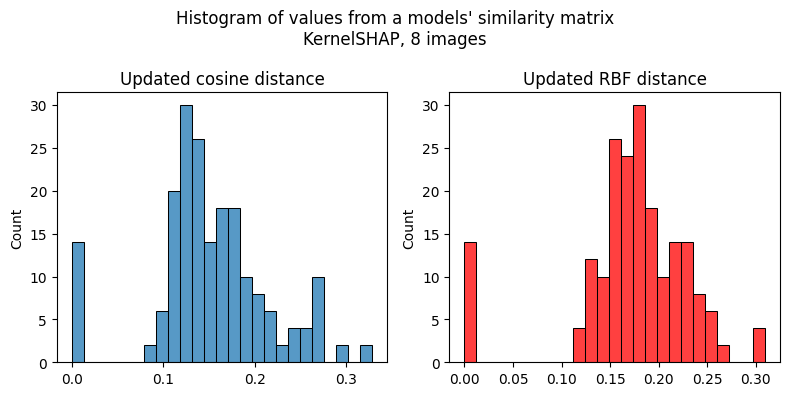

In [26]:
param=85
distance_df_cosine = compare_explanations(explanations_many_models_k, comparison_function=cosine_similarity_distance_with_stdev_and_mean)
distance_df_rbf = compare_explanations(explanations_many_models_k, comparison_function=partial(radial_basis_function_distance_with_stdev_and_mean, sigma=param))
plot_2_histograms(distance_df_cosine, distance_df_rbf, explanation_name="KernelSHAP", num_of_images=len(explanations_many_models_k[0]['explanations']))

In [18]:
radial_basis_function_distance_with_stdev_and_mean(explanations_many_models_g[0]['explanations'], explanations_many_models_g[1]['explanations'], sigma=80),\
cosine_similarity_distance_with_stdev_and_mean(explanations_many_models_g[0]['explanations'], explanations_many_models_g[1]['explanations'])

(0.18355324140134485, 0.42859537542853193)

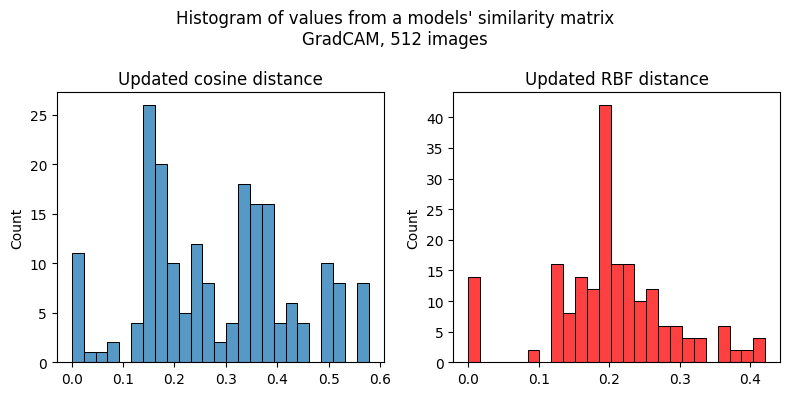

In [29]:
param=80
distance_df_cosine = compare_explanations(explanations_many_models_g, comparison_function=cosine_similarity_distance_with_stdev_and_mean)
distance_df_rbf = compare_explanations(explanations_many_models_g, comparison_function=partial(radial_basis_function_distance_with_stdev_and_mean, sigma=param))
plot_2_histograms(distance_df_cosine, distance_df_rbf, explanation_name="GradCAM", num_of_images=len(explanations_many_models_g[0]['explanations']))

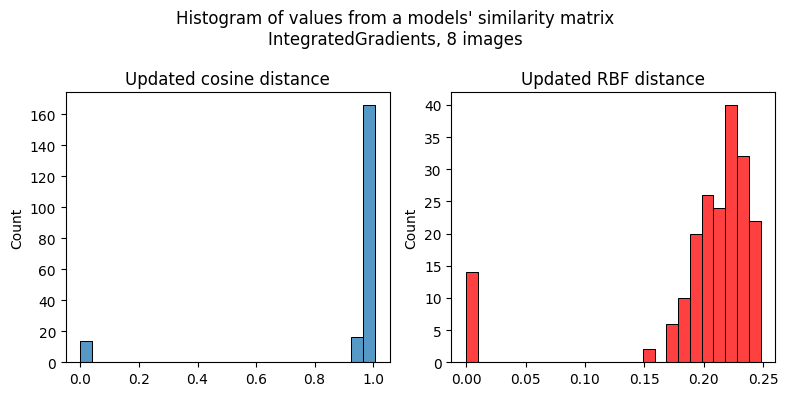

In [20]:
param=80
distance_df_cosine = compare_explanations(explanations_many_models_i, comparison_function=cosine_similarity_distance_with_stdev_and_mean)
distance_df_rbf = compare_explanations(explanations_many_models_i, comparison_function=partial(radial_basis_function_distance_with_stdev_and_mean, sigma=param))
plot_2_histograms(distance_df_cosine, distance_df_rbf, explanation_name="IntegratedGradients", num_of_images=len(explanations_many_models_i[0]['explanations']))